testing/weight-space/rq/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=1.000-a=0.100/spectral_density.bin
[[-4.      0.      0.    ]
 [ 8.5     0.      0.    ]
 [ 4.751   0.      0.    ]
 [ 2.877   0.      0.    ]
 [ 7.5645  0.      0.    ]]


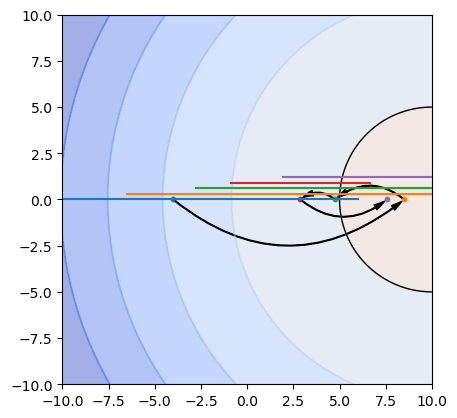

In [37]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.stats
import scipy.special
import utils
import matplotlib.patches as patches

def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

def gt_spec_se(xs, l=1, sigma=1):
    norm = 1.0 / (np.sqrt(np.pi/2) * sigma**2)
    return norm*(np.exp(-0.5 * l**2 * xs**2) * sigma**2)/np.sqrt(1/l**2)


def gt_spec_rq(xs, l=1, sigma=1, a=1):
    xs = np.maximum(xs, 0.00001)
    norm = 1.0 / (np.sqrt(np.pi/2) * sigma**2)
    return norm*(np.power(2., 5. / 4. - a / 2) * np.power(1 / (a * l * l), -(1. / 4.) - a /
                2) * sigma * sigma * np.power(abs(xs), -0.5 + a) *
                scipy.special.kv(0.5 - a, (np.sqrt(2) * np.abs(xs)) / np.sqrt(1. / (a * l * l)))) / scipy.special.gamma(a)

for file in glob.glob("testing/weight-space/*/*/spectral_density.bin"):
    file = file.replace("\\", "/")
    print(file)

    res = 512
    spectrum = np.reshape(np.fromfile(file, dtype=np.float64), (-1))
    samples = np.reshape(np.fromfile(file.replace("spectral_density.bin", "spectral_density_samples.bin"), dtype=np.float64), (-1))
    real = np.reshape(np.fromfile(file.replace("spectral_density.bin", "grid-samples.bin"), dtype=np.float64), (res,res)).T
    ray_ps = np.reshape(np.fromfile(file.replace("spectral_density.bin", "ray-points.bin"), dtype=np.float64), (-1,3))
    ray_ds = np.reshape(np.fromfile(file.replace("spectral_density.bin", "ray-distances.bin"), dtype=np.float64), (-1))
    affine_interval_cs = np.reshape(np.fromfile(file.replace("spectral_density.bin", "affine-interval-centers.bin"), dtype=np.float64), (-1,3))
    affine_interval_sizes = np.reshape(np.fromfile(file.replace("spectral_density.bin", "affine-interval-sizes.bin"), dtype=np.float64), (-1))

    xs = np.linspace(-10, 10, real.shape[0])
    xx, yy = np.meshgrid(xs,xs)
    utils.plot_realization(real, plt.gca(), xx, yy,clw=1)

    #plt.scatter(ray_ps[:,0], ray_ps[:,1], s=10, c="grey")
    #plt.plot(ray_ps[:,0], ray_ps[:,1], c="grey")
    #circles(ray_ps[:,0], ray_ps[:,1], ray_ds, c="grey", facecolor=None, alpha=0.3, ls='--', zorder=10)
    
    print(affine_interval_cs)
    #plt.scatter(affine_interval_cs[:,0], affine_interval_cs[:,1], s=10, c="grey")

    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="k")

    for i, c in enumerate(affine_interval_cs):
        p = plt.scatter(affine_interval_cs[i,0], affine_interval_cs[i,1], s=10)
        plt.plot([affine_interval_cs[i,0] - affine_interval_sizes[i]*0.5, affine_interval_cs[i,0] + affine_interval_sizes[i]*0.5], [affine_interval_cs[i,1] + i*0.3, affine_interval_cs[i,1]+ i*0.3],c=p.get_facecolor())

        if(i < affine_interval_cs.shape[0]-1):
            plt.gca().add_patch(patches.FancyArrowPatch(affine_interval_cs[i,:2], affine_interval_cs[i+1,:2],
                             connectionstyle="arc3,rad=.4", **kw))

    #plt.plot(ray_ps[:,0], ray_ps[:,1], c="grey")
    #circles(ray_ps[:,0], ray_ps[:,1], ray_ds, c="grey", facecolor=None, alpha=0.3, ls='--', zorder=10)

    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

    plt.show()

    #xs = np.linspace(0, 10, len(spectrum))
    #plt.ylim(0, 1.1)
    #plt.plot(xs, spectrum)
    #plt.hist(samples, range=(0,10), density=True, bins=100)

    plt.show()

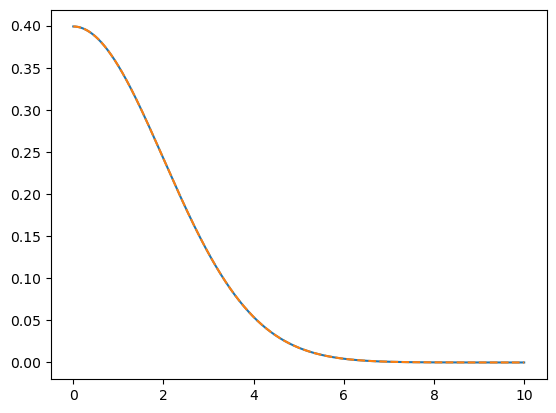

In [2]:
def normal_pdf(xs, mean, stddev):
    return 1/(stddev*np.sqrt(2*np.pi)) * np.exp(-0.5*((xs-mean)/stddev)**2)

l = 0.5
sigma = 1

plt.plot(xs, gt_spec_se(xs, l=l, sigma=sigma))
plt.plot(xs, normal_pdf(xs, 0, 1/l)*2, "--")

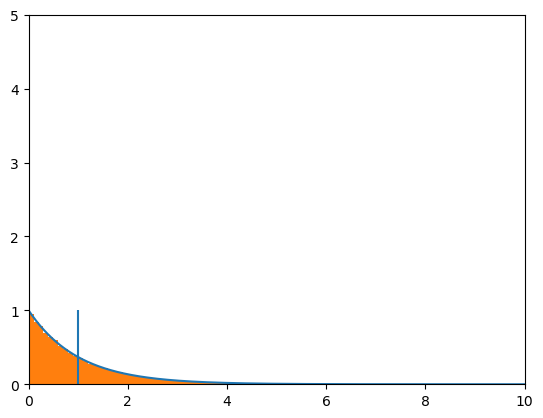

In [3]:
l = 1
sigma = 1
a = 1
xs = np.linspace(0, 10, 1000)

def gamma(xs, a, b):
    return xs**(a-1) * np.exp(- (a*xs)/b) / ((a/b)**(-a) *scipy.special.gamma(a) )

def gamma_sample_mean(shape,mean,n=None):
    scale = mean/shape
    return np.random.gamma(shape, scale, n)

plt.plot(xs, gamma(xs,a,1/l**2))
samples = gamma_sample_mean(a,1/l**2,100000)
plt.hist(samples, density=True, range=(0,20), bins=200)
plt.vlines(np.mean(samples), 0, 1)
plt.xlim(0,10)
plt.ylim(0, 5)
plt.show()



(0.0, 1.1)

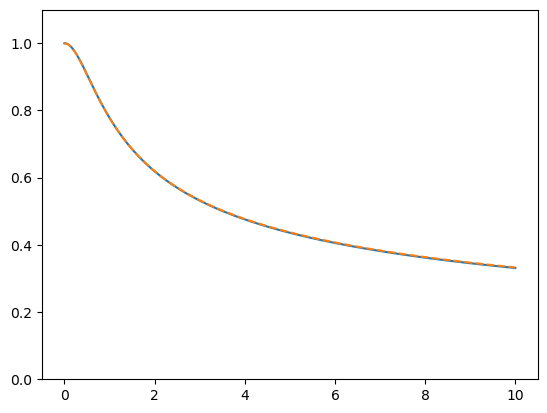

In [28]:
l = 1
sigma = 1
a = 0.2
xs = np.linspace(0, 10, 1000)

def gt_rq(xs, l, sigma, a):
    return sigma**2 * (1 + xs**2/(2*a*l**2))**(-a)

def gt_se(xs, ls, sigma):
    return sigma**2 * np.exp(- xs**2/(2*ls**2))

plt.plot(xs, gt_rq(xs, l, sigma, a))

samples = np.zeros_like(xs)
n_samples = 100000
for i in range(n_samples):
    tau = gamma_sample_mean(a, 1/l**2)
    ls = 1 / tau ** 0.5
    samples += gt_se(xs, ls, sigma)
samples /= n_samples

plt.plot(xs, samples, "--")

plt.ylim(0, 1.1)

(0.0, 1.1)

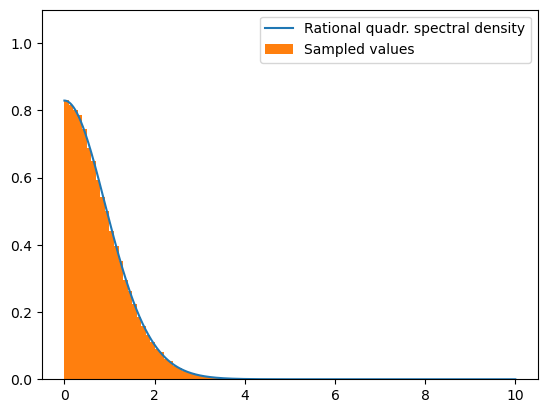

In [29]:
l = 1
sigma = 0.5
a = 10
xs = np.linspace(0, 10, 100000)

plt.plot(xs, gt_spec_rq(xs, l=l, sigma=sigma,a=a), label="Rational quadr. spectral density")

samples = []
for i in range(100000):
    tau = gamma_sample_mean(a, 1/l**2)
    ls = 1 / tau ** 0.5
    samples.append(np.abs(np.random.normal(0,1/ls)))

plt.hist(samples, density=True, range=(0,10), bins=100, label="Sampled values")
plt.legend()
plt.ylim(0, 1.1)